In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

from metrics import calculate_metrics

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=300)
pd.set_option('display.max_columns', None)
seed = 10
np.random.seed(seed)

R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.
/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a 

In [8]:
def run_cell_anova(adata, batch_key, condition_key, control_name, cell_type_label, dataset_name):
    if np.max(adata.X) > 15:
        sc.pp.filter_cells(adata, min_genes=300)
        sc.pp.filter_genes(adata, min_cells=10)

        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)

    if adata.shape[1] > 3000:
        sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key=batch_key)
        adata = adata[:, adata.var["highly_variable"]].copy()
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=adata.shape[1], batch_key=batch_key)

    import warnings

    # Suppress all warnings
    warnings.filterwarnings("ignore")

    integrate_key = batch_key
    adata.obs['dataidx'] = adata.obs[batch_key].copy()
    #adata_prep = cnova.model.preprocess_data(adata, integrate_key='dataidx')

    batch = np.unique(adata.obs[integrate_key])
    list_batch = []
    for x in batch:
        adata_iter = adata[adata.obs[integrate_key] == x]
        list_batch.append(adata_iter)

    adata_prep = ad.concat(list_batch)
    adata_prep.layers['lognorm'] = adata_prep.X
    
    if adata.shape[1] > 3000:
        sc.pp.highly_variable_genes(adata_prep, n_top_genes=3000, batch_key=batch_key)
        adata_prep = adata_prep[:, adata.var["highly_variable"]].copy()
    else:
        sc.pp.highly_variable_genes(adata_prep, n_top_genes=adata.shape[1], batch_key=batch_key)
    
    sc.pp.scale(adata_prep)
    adata_prep.layers['scale'] = adata_prep.X

    control_batches = list(set(adata_prep[adata_prep.obs[condition_key] == control_name,].obs[batch_key]))
    control_dict = {
        'g1': control_batches,
    }
    adata_prep = cnova.model.calc_ME(adata_prep, integrate_key='dataidx')
    adata_prep = cnova.model.calc_BE(adata_prep, integrate_key, control_dict)
    adata_prep = cnova.model.calc_TE(adata_prep, integrate_key)
    print(control_dict)
    adata_prep.obs['PseudoState'] = adata_prep.obs[condition_key].copy()
    adata_prep.write_h5ad("./cellanova/" + dataset_name + "_results.h5ad")

    integrated = ad.AnnData(adata_prep.layers['denoised'], dtype=np.float32)
    integrated.obs = adata_prep.obs.copy()
    integrated.var_names = adata_prep.var_names

    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15, n_pcs=30)
    sc.tl.umap(integrated)
    if cell_type_label is not None:
        sc.pl.umap(integrated, color=['dataidx', cell_type_label],ncols=1)
    else:
        sc.pl.umap(integrated, color='dataidx')
    
    res = cnova.utils.calc_oobNN(integrated, batch_key='dataidx', condition_key='PseudoState')
    df = res.obsm['knn_prop']
    df['condition'] = res.obs['PseudoState']
    df.index.name = "index"
    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./cellanova/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('CellANOVA integration')
    sea.set_style('white')
    plt.show()

# (EC)CITE-seq

https://www.nature.com/articles/s41588-021-00778-2

In [ ]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
run_cell_anova(adata=adata, batch_key='replicate', condition_key='perturbation', control_name='NT', cell_type_label="Phase", dataset_name="ECCITE")

In [10]:
adata_prep=sc.read_h5ad("./cellanova/" + "ECCITE" + "_results.h5ad")
integrated = ad.AnnData(adata_prep.layers['denoised'], dtype=np.float32)
integrated.obs = adata_prep.obs.copy()
integrated.var_names = adata_prep.var_names
res = cnova.utils.calc_oobNN(integrated, batch_key='dataidx', condition_key='PseudoState')
print(res.obsm['knn_prop'])

                         ATF2      BRD4      CAV1      CD86     CMTM6  \
index                                                                   
l1_AAACCTGAGCCAGAAC  0.071429  0.000000  0.071429  0.000000  0.071429   
l1_AAACCTGAGTGGACGT  0.000000  0.000000  0.000000  0.071429  0.142857   
l1_AAACCTGCATGAGCGA  0.000000  0.000000  0.000000  0.000000  0.000000   
l1_AAACCTGTCTTGTCAT  0.000000  0.000000  0.071429  0.071429  0.000000   
l1_AAACGGGAGAACAACT  0.000000  0.071429  0.071429  0.071429  0.142857   
...                       ...       ...       ...       ...       ...   
l8_TTTGTCAAGACTTGAA  0.000000  0.071429  0.071429  0.000000  0.000000   
l8_TTTGTCAGTCACTTCC  0.071429  0.000000  0.000000  0.071429  0.000000   
l8_TTTGTCAGTTCCACAA  0.000000  0.142857  0.000000  0.000000  0.071429   
l8_TTTGTCATCACGCATA  0.071429  0.142857  0.000000  0.142857  0.071429   
l8_TTTGTCATCTGTACGA  0.071429  0.000000  0.000000  0.000000  0.071429   

                         CUL3      ETV7    IFNGR1 

# ASD

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

2025-01-07 20:38:09,361 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-07 20:38:12,339 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-07 20:38:12,493 - harmonypy - INFO - Iteration 1 of 30
2025-01-07 20:38:21,362 - harmonypy - INFO - Iteration 2 of 30
2025-01-07 20:38:30,297 - harmonypy - INFO - Iteration 3 of 30
2025-01-07 20:38:39,167 - harmonypy - INFO - Iteration 4 of 30
2025-01-07 20:38:48,135 - harmonypy - INFO - Iteration 5 of 30
2025-01-07 20:38:53,630 - harmonypy - INFO - Iteration 6 of 30
2025-01-07 20:38:58,417 - harmonypy - INFO - Iteration 7 of 30
2025-01-07 20:39:02,034 - harmonypy - INFO - Iteration 8 of 30
2025-01-07 20:39:05,297 - harmonypy - INFO - Iteration 9 of 30
2025-01-07 20:39:08,533 - harmonypy - INFO - Iteration 10 of 30
2025-01-07 20:39:11,802 - harmonypy - INFO - Converged after 10 iterations


{'g1': ['3', '6', '14', '8', '11', '1', '5', '16', '15', '7', '18', '10', '4', '12', '9', '13', '2']}


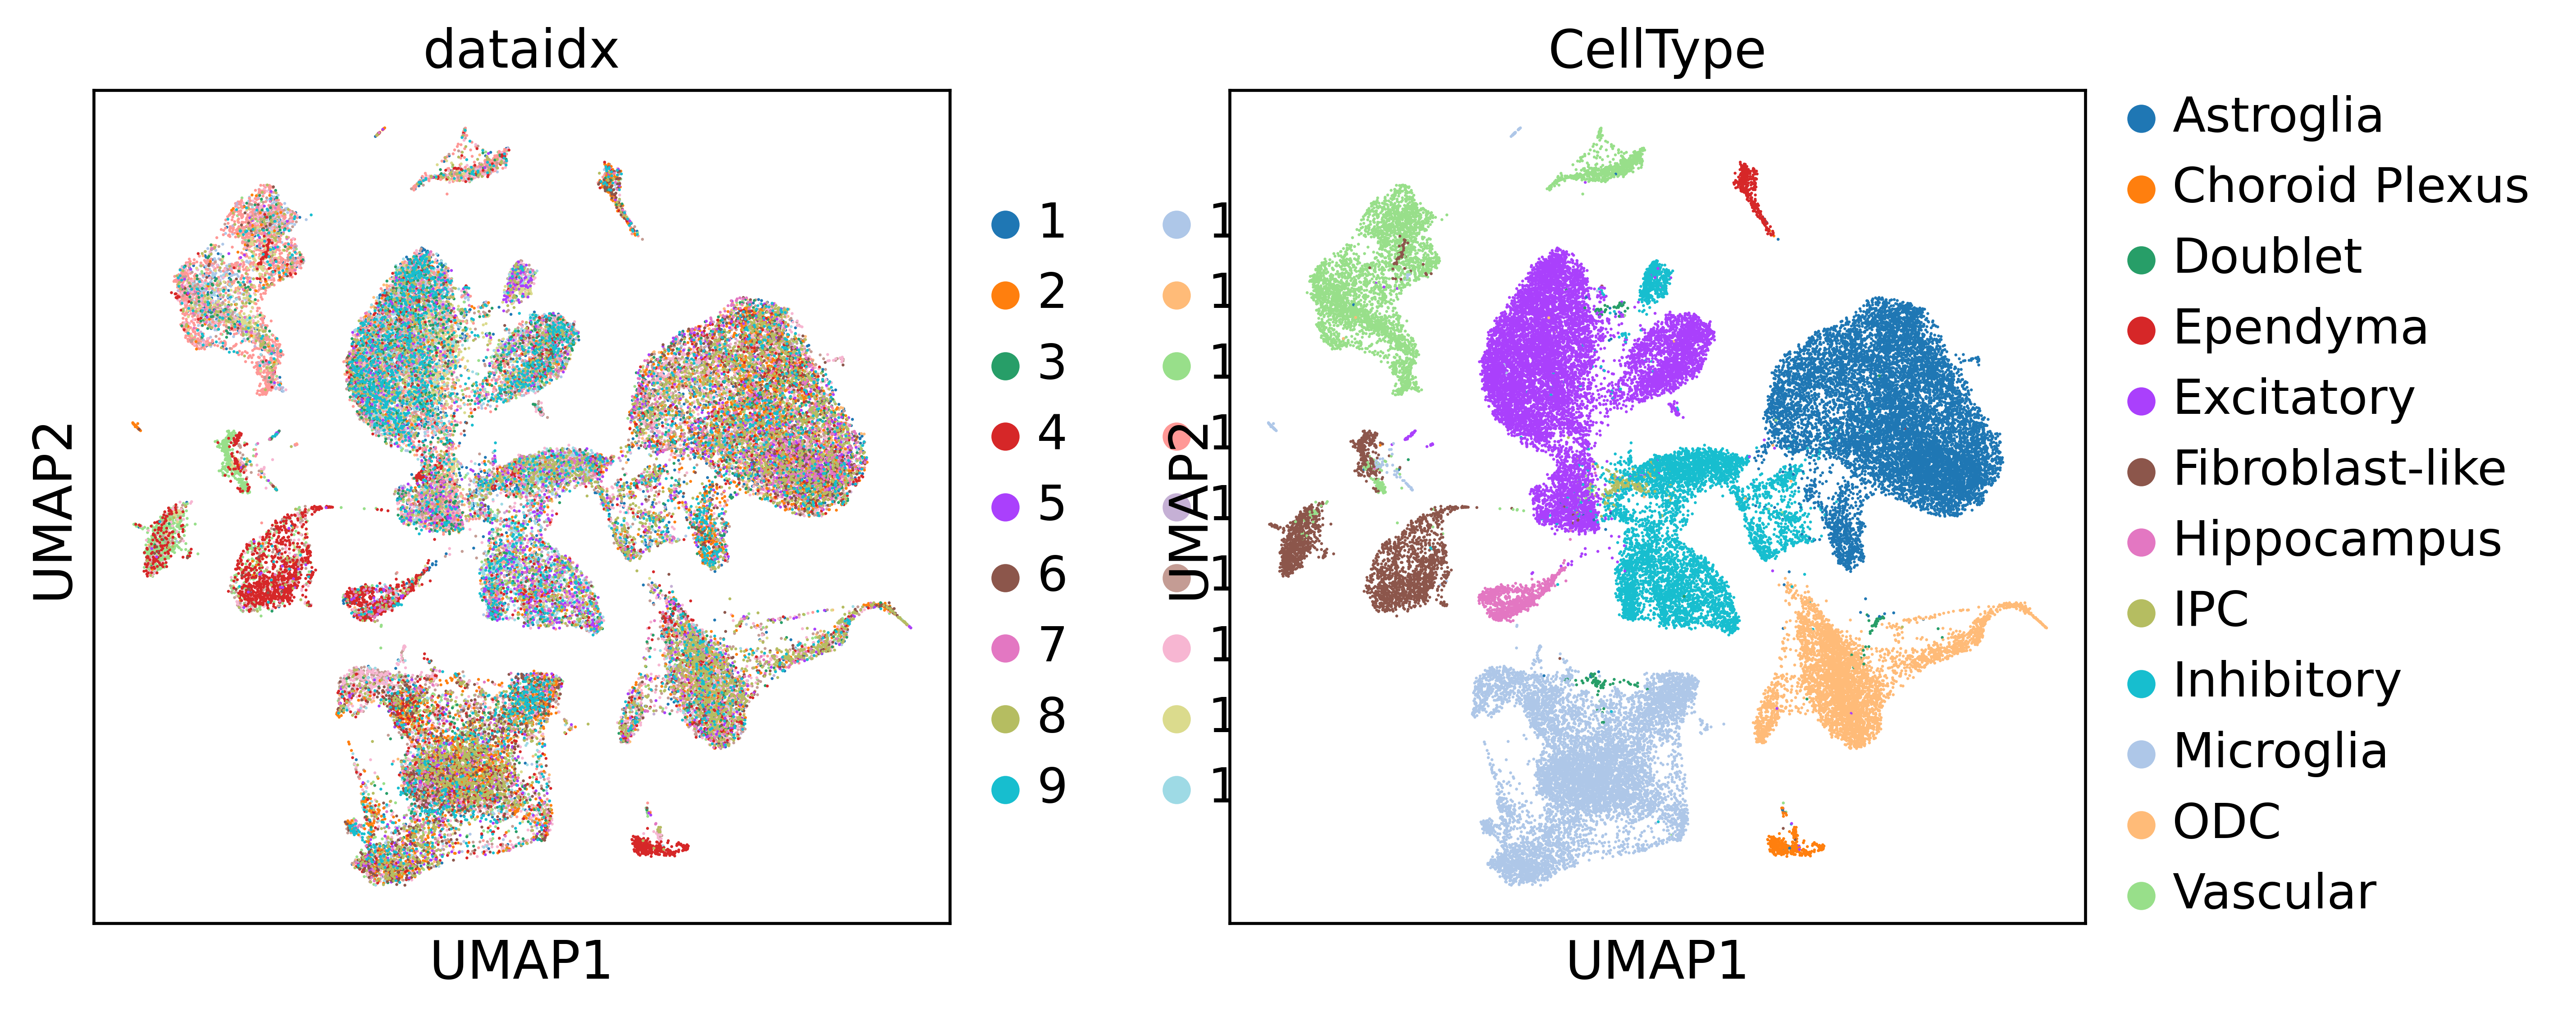

                                mutated       nan
NAME                                             
PertCortex_1_AAACCTGAGAAGCCCA  0.500000  0.500000
PertCortex_1_AAACCTGAGCCACGTC  1.000000  0.000000
PertCortex_1_AAACCTGAGGATCGCA  0.357143  0.642857
PertCortex_1_AAACCTGAGTTCGATC  0.357143  0.642857
PertCortex_1_AAACCTGCAAAGCAAT  0.428571  0.571429
...                                 ...       ...
PertCortex_9_TTTGTCAGTCGCATCG  0.571429  0.428571
PertCortex_9_TTTGTCAGTCTCCCTA  0.642857  0.357143
PertCortex_9_TTTGTCAGTGATGATA  0.214286  0.785714
PertCortex_9_TTTGTCAGTTTGTTTC  0.571429  0.428571
PertCortex_9_TTTGTCATCGAACGGA  1.000000  0.000000

[49067 rows x 2 columns]
['mutated', 'nan', 'condition']
['NAME', 'mutated', 'nan', 'condition']
                                NAME   mutated       nan condition
0      PertCortex_1_AAACCTGAGAAGCCCA  0.500000  0.500000   mutated
1      PertCortex_1_AAACCTGAGCCACGTC  1.000000  0.000000   mutated
2      PertCortex_1_AAACCTGAGGATCGCA  0.357143  0.6

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['index']"

In [9]:
adata=sc.read_h5ad("../data/ASD.h5ad")
run_cell_anova(adata=adata, batch_key='Batch', condition_key='perturb01', control_name='nan', cell_type_label="CellType", dataset_name="ASD")

In [41]:
adata_prep=sc.read_h5ad("./cellanova/" + "ASD" + "_results.h5ad")
integrated = ad.AnnData(adata_prep.layers['denoised'], dtype=np.float32)
integrated.obs = adata_prep.obs.copy()
integrated.var_names = adata_prep.var_names
res = cnova.utils.calc_oobNN(integrated, batch_key='dataidx', condition_key='PseudoState')
print(res.obsm['knn_prop'])

                                mutated       nan
NAME                                             
PertCortex_1_AAACCTGAGAAGCCCA  0.500000  0.500000
PertCortex_1_AAACCTGAGCCACGTC  1.000000  0.000000
PertCortex_1_AAACCTGAGGATCGCA  0.357143  0.642857
PertCortex_1_AAACCTGAGTTCGATC  0.357143  0.642857
PertCortex_1_AAACCTGCAAAGCAAT  0.428571  0.571429
...                                 ...       ...
PertCortex_9_TTTGTCAGTCGCATCG  0.571429  0.428571
PertCortex_9_TTTGTCAGTCTCCCTA  0.642857  0.357143
PertCortex_9_TTTGTCAGTGATGATA  0.214286  0.785714
PertCortex_9_TTTGTCAGTTTGTTTC  0.571429  0.428571
PertCortex_9_TTTGTCATCGAACGGA  1.000000  0.000000

[49067 rows x 2 columns]


In [45]:
df = res.obsm['knn_prop']
print(df)
# Add the 'condition' column
df['condition'] = res.obs['PseudoState']
df.index.name = "index"
'''
df = df.rename(columns={"nan": "not_perturbed"})
df["condition"] = df["condition"].replace("nan", "not_perturbed")
df["index"]=df.index
print(df.columns.tolist())
'''
df = df.reset_index()
print(df)
df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
print(df)

                                mutated       nan condition
NAME                                                       
PertCortex_1_AAACCTGAGAAGCCCA  0.500000  0.500000   mutated
PertCortex_1_AAACCTGAGCCACGTC  1.000000  0.000000   mutated
PertCortex_1_AAACCTGAGGATCGCA  0.357143  0.642857   mutated
PertCortex_1_AAACCTGAGTTCGATC  0.357143  0.642857   mutated
PertCortex_1_AAACCTGCAAAGCAAT  0.428571  0.571429       nan
...                                 ...       ...       ...
PertCortex_9_TTTGTCAGTCGCATCG  0.571429  0.428571   mutated
PertCortex_9_TTTGTCAGTCTCCCTA  0.642857  0.357143   mutated
PertCortex_9_TTTGTCAGTGATGATA  0.214286  0.785714   mutated
PertCortex_9_TTTGTCAGTTTGTTTC  0.571429  0.428571   mutated
PertCortex_9_TTTGTCATCGAACGGA  1.000000  0.000000   mutated

[49067 rows x 3 columns]
                               index   mutated       nan condition
0      PertCortex_1_AAACCTGAGAAGCCCA  0.500000  0.500000   mutated
1      PertCortex_1_AAACCTGAGCCACGTC  1.000000  0.000000   m

# ASD1

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

In [ ]:
adata=sc.read_h5ad("../data/ASD1.h5ad")
run_cell_anova(adata=adata, batch_key='Batch', condition_key='perturb01', control_name='nan', cell_type_label="CellType", dataset_name="ASD1")